In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import sys
import os
# import gseapy as gp
import matplotlib.pyplot as plt
import swan_vis as swan
import yaml
from snakemake.io import expand
import cerberus

p = os.path.dirname(os.path.dirname(os.getcwd()))
sys.path.append(p)

from proc_revisions.utils import *
from proc_revisions.plotting import *


In [2]:
od = '../../proc_revisions/'
config_file = f'{od}/config.yml'
with open(config_file) as f:
    config = yaml.safe_load(f)

In [3]:
ab = od+expand(config['lr']['talon']['fusion_fix']['ab'], species='human')[0]
filt_ab = od+expand(config['lr']['cerberus']['filt_ab'], species='human')[0]
read_annot = od+expand(config['lr']['talon']['full_annot'], species='human')[0]
t_metadata = od+expand(config['ref']['cerberus']['new_gtf_t_info'], species='human')[0]
lib_meta = od+expand(config['lr']['meta'], species='human')[0]
swan_file = od+expand(config['lr']['swan']['sg'], species='human')[0]
cerberus_h5 = od+expand(config['lr']['cerberus']['ca_triplets'], species='human', obs_col='sample')[0]
cerb_t_metadata = od+expand(config['lr']['cerberus']['gtf_t_info'], species='human')[0]
major_isos = od+expand(config['lr']['analysis']['major_isos'], species='human', obs_col='sample')[0]
pi_tpm_table = od+expand(config['lr']['mane']['pi_tpm']['triplet'], species='human', obs_col='sample')[0]
pp_summary = od+expand(config['lr']['protein_pred']['summary'], species='human')[0]

ref_t_metadata = od+expand(config['ref']['new_gtf_t_info'], species='human')[0]
ref_g_metadata = od+expand(config['ref']['new_gtf_g_info'], species='human')[0]

m_lib_meta = od+expand(config['lr']['meta'], species='mouse')[0]

ver = 'v40_cerberus'
min_tpm = 1
gene_subset = 'protein_coding'
obs_col = 'sample'
go_gene_subset = 'protein_coding'

In [68]:
def assign_param_search_sector(df, kind, thresh, top='splicing_ratio'):
    """
    Assign each gene triplet a sector based on 
    altering one threshold

    Parameters:
        df (pandas DataFrame): DataFrame with simplex coordinates and n_iso
        kind (str): 'tss', 'ic', 'tes'
        thresh (float): Threshold to use
        top: (str): {'splicing_ratio', 'n_ic'}

    Returns:
        df (pandas DataFrame): DataFrame with sector listed
    """
    temp = df.copy(deep=True)
    
    if kind == 'tss':
        thing = 'tss_ratio'
        thing2 = 'tss'
    elif kind == 'ic':
        thing = 'spl_ratio'
        thing2 = 'splicing'
    elif kind == 'tes':
        thing = 'tes_ratio'
        thing2 = 'tes'
        
    if top == 'n_ic':
        # recalc
        temp['tss_ratio'] = temp.n_tss/(temp.n_tss+temp.n_ic+temp.n_tes)
        temp['spl_ratio'] = temp.n_ic/(temp.n_tss+temp.n_ic+temp.n_tes)
        temp['tes_ratio'] = temp.n_tes/(temp.n_tss+temp.n_ic+temp.n_tes)
        
    # df['sector'] = f'not_{thing2}'
    temp['sector'] = np.nan

    temp.loc[temp[thing] > thresh, 'sector'] = thing2
    
    
    return temp

In [69]:
ca = cerberus.read(cerberus_h5)
df = ca.triplets.copy(deep=True)
df = df.loc[df.source=='obs_det']

## w/o splicing ratio

In [70]:
big_df = pd.DataFrame()
for feat in ['tss', 'ic', 'tes']:
    for i in range(0, 100):
        thresh = i/100
        temp = assign_param_search_sector(df, feat, thresh, top='n_ic')
        temp = temp[['gid', 'sector']].groupby('sector').count().reset_index().rename({'gid':'n_genes'}, axis=1)
        temp['feat'] = feat
        temp['thresh'] = thresh
        big_df = pd.concat([big_df, temp], axis=0)    
        # if i%10 == 0:
        #     print(i)

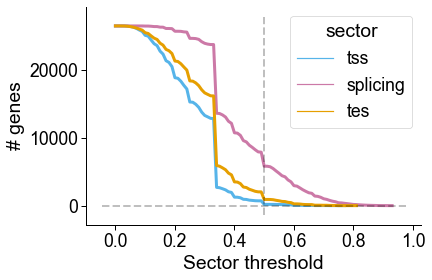

In [71]:
sns.set_context('paper', font_scale=2)
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['pdf.fonttype'] = 42
c_dict, order = get_sector_colors()
ax = sns.lineplot(big_df, hue='sector', y='n_genes', x='thresh', linewidth=3, palette=c_dict)
ax.set(xlabel='Sector threshold', ylabel='# genes')
ylims = ax.get_ylim()
xlims = ax.get_xlim()

ax.vlines(0.5, ylims[0], ylims[1],
                      colors='k', linestyles='dashed',
                      linewidth=2, alpha=0.25)
ax.hlines(0, xlims[0], xlims[1],
                      colors='k', linestyles='dashed',
                      linewidth=2, alpha=0.25)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

In [72]:
big_df.head()

,sector,n_genes,feat,thresh
0,tss,26544,tss,0.00
0,tss,26544,tss,0.01
0,tss,26543,tss,0.02
0,tss,26541,tss,0.03
0,tss,26515,tss,0.04


## w/ splicing ratio

In [73]:
big_df = pd.DataFrame()
for feat in ['tss', 'ic', 'tes']:
    for i in range(0, 100):
        thresh = i/100
        temp = assign_param_search_sector(df, feat, thresh)
        temp = temp[['gid', 'sector']].groupby('sector').count().reset_index().rename({'gid':'n_genes'}, axis=1)
        temp['feat'] = feat
        temp['thresh'] = thresh
        big_df = pd.concat([big_df, temp], axis=0)    
        # if i%10 == 0:
        #     print(i)

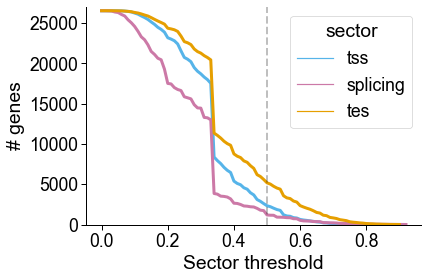

In [78]:
sns.set_context('paper', font_scale=2)
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['pdf.fonttype'] = 42
c_dict, order = get_sector_colors()
ax = sns.lineplot(big_df, hue='sector', y='n_genes', x='thresh', linewidth=3, palette=c_dict)
ax.set(xlabel='Sector threshold', ylabel='# genes', ylim=(0,27000))
ylims = ax.get_ylim()
xlims = ax.get_xlim()

ax.vlines(0.5, ylims[0], ylims[1],
                      colors='k', linestyles='dashed',
                      linewidth=2, alpha=0.25)
# ax.hlines(0, xlims[0], xlims[1],
#                       colors='k', linestyles='dashed',
#                       linewidth=2, alpha=0.25)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)